This file intends to provide a suite of tools for analyzing a low-resolution stage run of this example.

In [1]:
using ProtoSyn
using ProtoSyn.Peptides
using Printf

ProtoSyn will now only display error messages. Debug: ⨯ | Info: ⨯ | Warnings: ⨯ | Errors: ✓
[ Loading: External packages
 | Loading SIMD
 | Loading CUDA
[ Loading: Setting up global variables
 | Current acceleration set to ProtoSyn.CUDA_2
[ Loading: Core module
 | Loading Calculators
 | Loading Mutators
 | Loading Drivers
[ Loading: Peptides module
[ Loading: Materials module
[ Loading: Sugars module
[ Loading: Common module
[ Loading: External models
 | Loading TorchANI
 | Loading ONNX models
 | Loading PyRosetta
 | Loading SeqDes
[ Loading: ProtoSyn loaded successfully!

.      ____            _       ____              
      |  _ \ _ __ ___ | |_ ___/ ___| _   _ _ __  
      | |_) | '__/ _ \| __/ _ \___ \| | | | '_ \ 
      |  __/| | | (_) | || (_) |__) | |_| | | | |
      |_|   |_|  \___/ \__\___/____/ \__, |_| |_|
                                       |_/       
    
      ---------------------------------------------

 Version      : 1.10
 License      : GNU-GPL-3
 Developed by :

In [2]:
using DataFrames
using CSV
using Plots

In order to compare candidate predictions with a crystallographic structure, we must first establish the base truth.

In [3]:
base_truth = ProtoSyn.Peptides.load("../data/2a3d.pdb")
res_lib    = ProtoSyn.Peptides.grammar
ProtoSyn.Peptides.remove_sidechains!(base_truth, res_lib)

Pose{Topology}(Topology{/2a3d:57134}, State{Float64}:
 Size: 521
 i2c: false | c2i: false
 Energy: Dict(:Total => Inf)
)

1. The follwoing methods allow users to analyze a replica energy evolution over time, by reading the .log files.

In [4]:
function plot_simulation_data(filename::String)
    !isfile(filename) && return
    data = CSV.read(filename, DataFrame)
    fname = splitpath(filename)[end]

    outer       = 0
    N_steps     = 0
    inner       = Vector{Int}()
    for i in eachrow(data)
        if i.DRIVER == "OUTER"
            if i.STEP == 1
                N_steps = inner[end]
            end
            outer = i.STEP
        else
            push!(inner, i.STEP + N_steps * outer)

        end
    end

    inner_data = filter(row -> row.DRIVER == "INNER", data)
    inner_data[:, :TOTAL_STEP] = inner;

    # show(inner_data, allcols = true)

    function plot_inner_data(inner_data::DataFrame, base_truth::Opt{Pose})
        plot_data = filter(x -> x.ENERGY < 50.0, inner_data)
        # plot_data = copy(inner_data)
        p1 = plot(plot_data.TOTAL_STEP, plot_data.ENERGY, label = "Total", legend = :outerright, color = :orchid, xrotation = 45, margin = 5Plots.mm)
        for name in names(data)[6:end]
            plot!(plot_data.TOTAL_STEP, plot_data[:, name], label = name, alpha = 0.5)
        end
        # hline!([base_truth.state.e[:Total]], ls = :dash, color = :grey, alpha = 0.5, label = "Base truth")
    
        outer_data = filter(row -> row.DRIVER == "OUTER", data)
        outer_data[:, :TOTAL_STEP] = outer_data[:, :STEP] .* N_steps
        best = outer_data[findmin(outer_data.ENERGY)[2], :]
        scatter!([best.TOTAL_STEP], [best.ENERGY], label = "Best structure", msw = 0.3, color = :orchid)
        println("Best structure is #$(best.STEP + 2) : E: $(best.ENERGY)")
    
        p21 = plot(plot_data.TOTAL_STEP, plot_data.ACCEPTANCE_RATIO, label = "Acceptance ratio", legend = :outerright, color = :green, xrotation = 45, margin = 5Plots.mm)
        p22 = plot(plot_data.TOTAL_STEP, plot_data.TEMPERATURE, label = "Temperature", legend = :outerright, color = :orange, xrotation = 45)
        p2 = plot(p21, p22, layout = (1, 2))
        p = plot(p1, p2, layout = (2, 1), size = (1000, 400))
        display(p)
    end

    plot_inner_data(inner_data, base_truth)
end

plot_simulation_data (generic function with 1 method)

In [5]:
function plot_data(data::DataFrame, base_truth::Opt{Pose})
    # plot_data = filter(x -> x.ENERGY < 50.0, inner_data)
    plot_data = copy(data)
    p1 = plot(plot_data.STEP, plot_data.ENERGY, label = "Total", legend = :outerright, color = :orchid, xrotation = 45, margin = 5Plots.mm)
    for name in names(data)[6:end]
        plot!(plot_data.STEP, plot_data[:, name], label = name, alpha = 0.5)
    end
    # hline!([base_truth.state.e[:Total]], ls = :dash, color = :grey, alpha = 0.5, label = "Base truth")

    p21 = plot(plot_data.STEP, plot_data.ACCEPTANCE_RATIO, label = "Acceptance ratio", legend = :outerright, color = :green, xrotation = 45, margin = 5Plots.mm)
    p22 = plot(plot_data.STEP, plot_data.TEMPERATURE, label = "Temperature", legend = :outerright, color = :orange, xrotation = 45)
    p2 = plot(p21, p22, layout = (1, 2))
    p = plot(p1, p2, layout = (2, 1), size = (1000, 400))
    display(p)
end

plot_data (generic function with 1 method)

An example of an output.

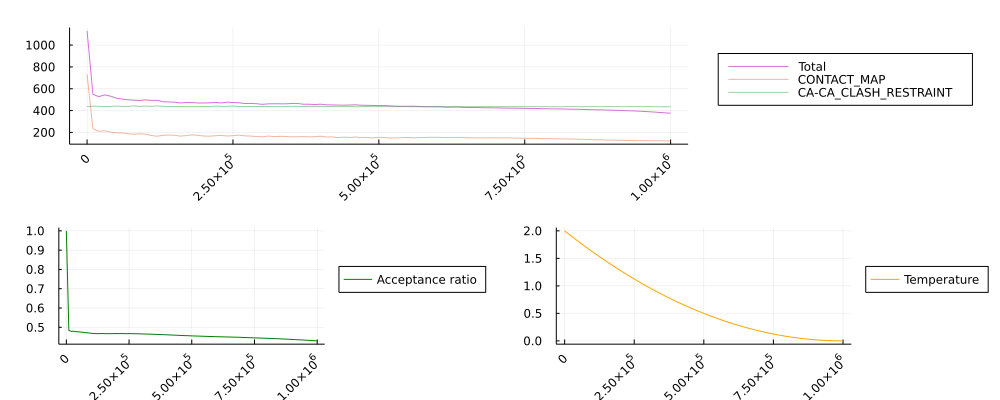

nothing

In [6]:
data = CSV.read("log_example.csv", DataFrame)
p = plot_data(data, base_truth)
display(p)

2. The next bit of code allows users to plot all replicas in a folding funnel plot (RMSD vs energy).

In [7]:
poses = Vector{Pose}([base_truth])

_poses = ProtoSyn.Peptides.load("distributed-results.pdb");
poses = vcat(poses, _poses)
println("Number of loaded poses: $(length(poses))")

Number of loaded poses: 617


In this case, RMSD is being measured using ProtoSyn.

In [8]:
using ProgressMeter
rmsd = Vector{Float64}()
@showprogress for pose in poses[1:end]
    ProtoSyn.align!(pose, base_truth, an"CA")
    push!(rmsd, ProtoSyn.rmsd(pose, base_truth, an"CA"))
end

Progress:   0%|▏                                        |  ETA: 0:27:07

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


First, users must re-load the same energy function used for the simulation that generated these structures (and re-evaluate all candidate structures). Note that, for some energy functions, charges must be set.

In [9]:
using Serialization
using ProtoSyn.Calculators: EnergyFunctionComponent

o_energy_function = open(deserialize, "energy_function.jls");

o_energies = Vector{Float64}()
@showprogress for pose in poses[1:end]
    push!(o_energies, o_energy_function(pose))
end

Progress:   0%|▏                                        |  ETA: 2:56:27

Progress:   2%|▊                                        |  ETA: 0:29:01

Progress:   4%|█▋                                       |  ETA: 0:14:16

Progress:   6%|██▍                                      |  ETA: 0:09:22

Progress:   8%|███▎                                     |  ETA: 0:06:45

Progress:  10%|████▏                                    |  ETA: 0:05:14

Progress:  12%|████▉                                    |  ETA: 0:04:18

Progress:  14%|█████▊                                   |  ETA: 0:03:38

Progress:  16%|██████▌                                  |  ETA: 0:03:07

Progress:  18%|███████▎                                 |  ETA: 0:02:43

Progress:  20%|████████▏                                |  ETA: 0:02:24

Progress:  22%|████████▉                                |  ETA: 0:02:10

Progress:  24%|█████████▊                               |  ETA: 0:01:56

Progress:  26%|██████████▋                              |  ETA: 0:01:43

Progress:  28%|███████████▍                             |  ETA: 0:01:33

Progress:  30%|████████████▎                            |  ETA: 0:01:25

Progress:  32%|█████████████                            |  ETA: 0:01:18

Progress:  34%|█████████████▉                           |  ETA: 0:01:11

Progress:  36%|██████████████▋                          |  ETA: 0:01:06

Progress:  38%|███████████████▌                         |  ETA: 0:01:00

Progress:  40%|████████████████▍                        |  ETA: 0:00:55

Progress:  42%|█████████████████▎                       |  ETA: 0:00:51

Progress:  44%|██████████████████▏                      |  ETA: 0:00:47

Progress:  46%|██████████████████▉                      |  ETA: 0:00:43

Progress:  48%|███████████████████▋                     |  ETA: 0:00:40

Progress:  50%|████████████████████▌                    |  ETA: 0:00:37

Progress:  52%|█████████████████████▎                   |  ETA: 0:00:35

Progress:  54%|██████████████████████                   |  ETA: 0:00:32

Progress:  56%|██████████████████████▉                  |  ETA: 0:00:30

Progress:  58%|███████████████████████▊                 |  ETA: 0:00:27

Progress:  60%|████████████████████████▋                |  ETA: 0:00:25

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:23

Progress:  64%|██████████████████████████▏              |  ETA: 0:00:22

Progress:  66%|███████████████████████████              |  ETA: 0:00:20

Progress:  68%|███████████████████████████▊             |  ETA: 0:00:18

Progress:  70%|████████████████████████████▋            |  ETA: 0:00:17

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:15

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:14

Progress:  76%|███████████████████████████████▎         |  ETA: 0:00:12

Progress:  78%|████████████████████████████████         |  ETA: 0:00:11

Progress:  80%|████████████████████████████████▉        |  ETA: 0:00:10

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:09

Progress:  84%|██████████████████████████████████▍      |  ETA: 0:00:07

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:06

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:05

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:04

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:03

Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:00:02

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:02

Progress:  98%|████████████████████████████████████████▎|  ETA: 0:00:01

Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


In [10]:
o_energy_function

🗲  Energy Function (3 components):
+----------------------------------------------------------------------+
| Index | Component name                                | Weight (α)   |
+----------------------------------------------------------------------+
| 1     | Caterpillar_Solv                              |       0.08   |
| 2     | Contact_Map                                   |       0.10   |
| 3     | Cα-Cα_Clash_Restraint                         |      10.00   |
+----------------------------------------------------------------------+
 ● Update forces: false
 ● Selection: Set
 └── TrueSelection (Atom)


It's now possible to plot the folding funnel.

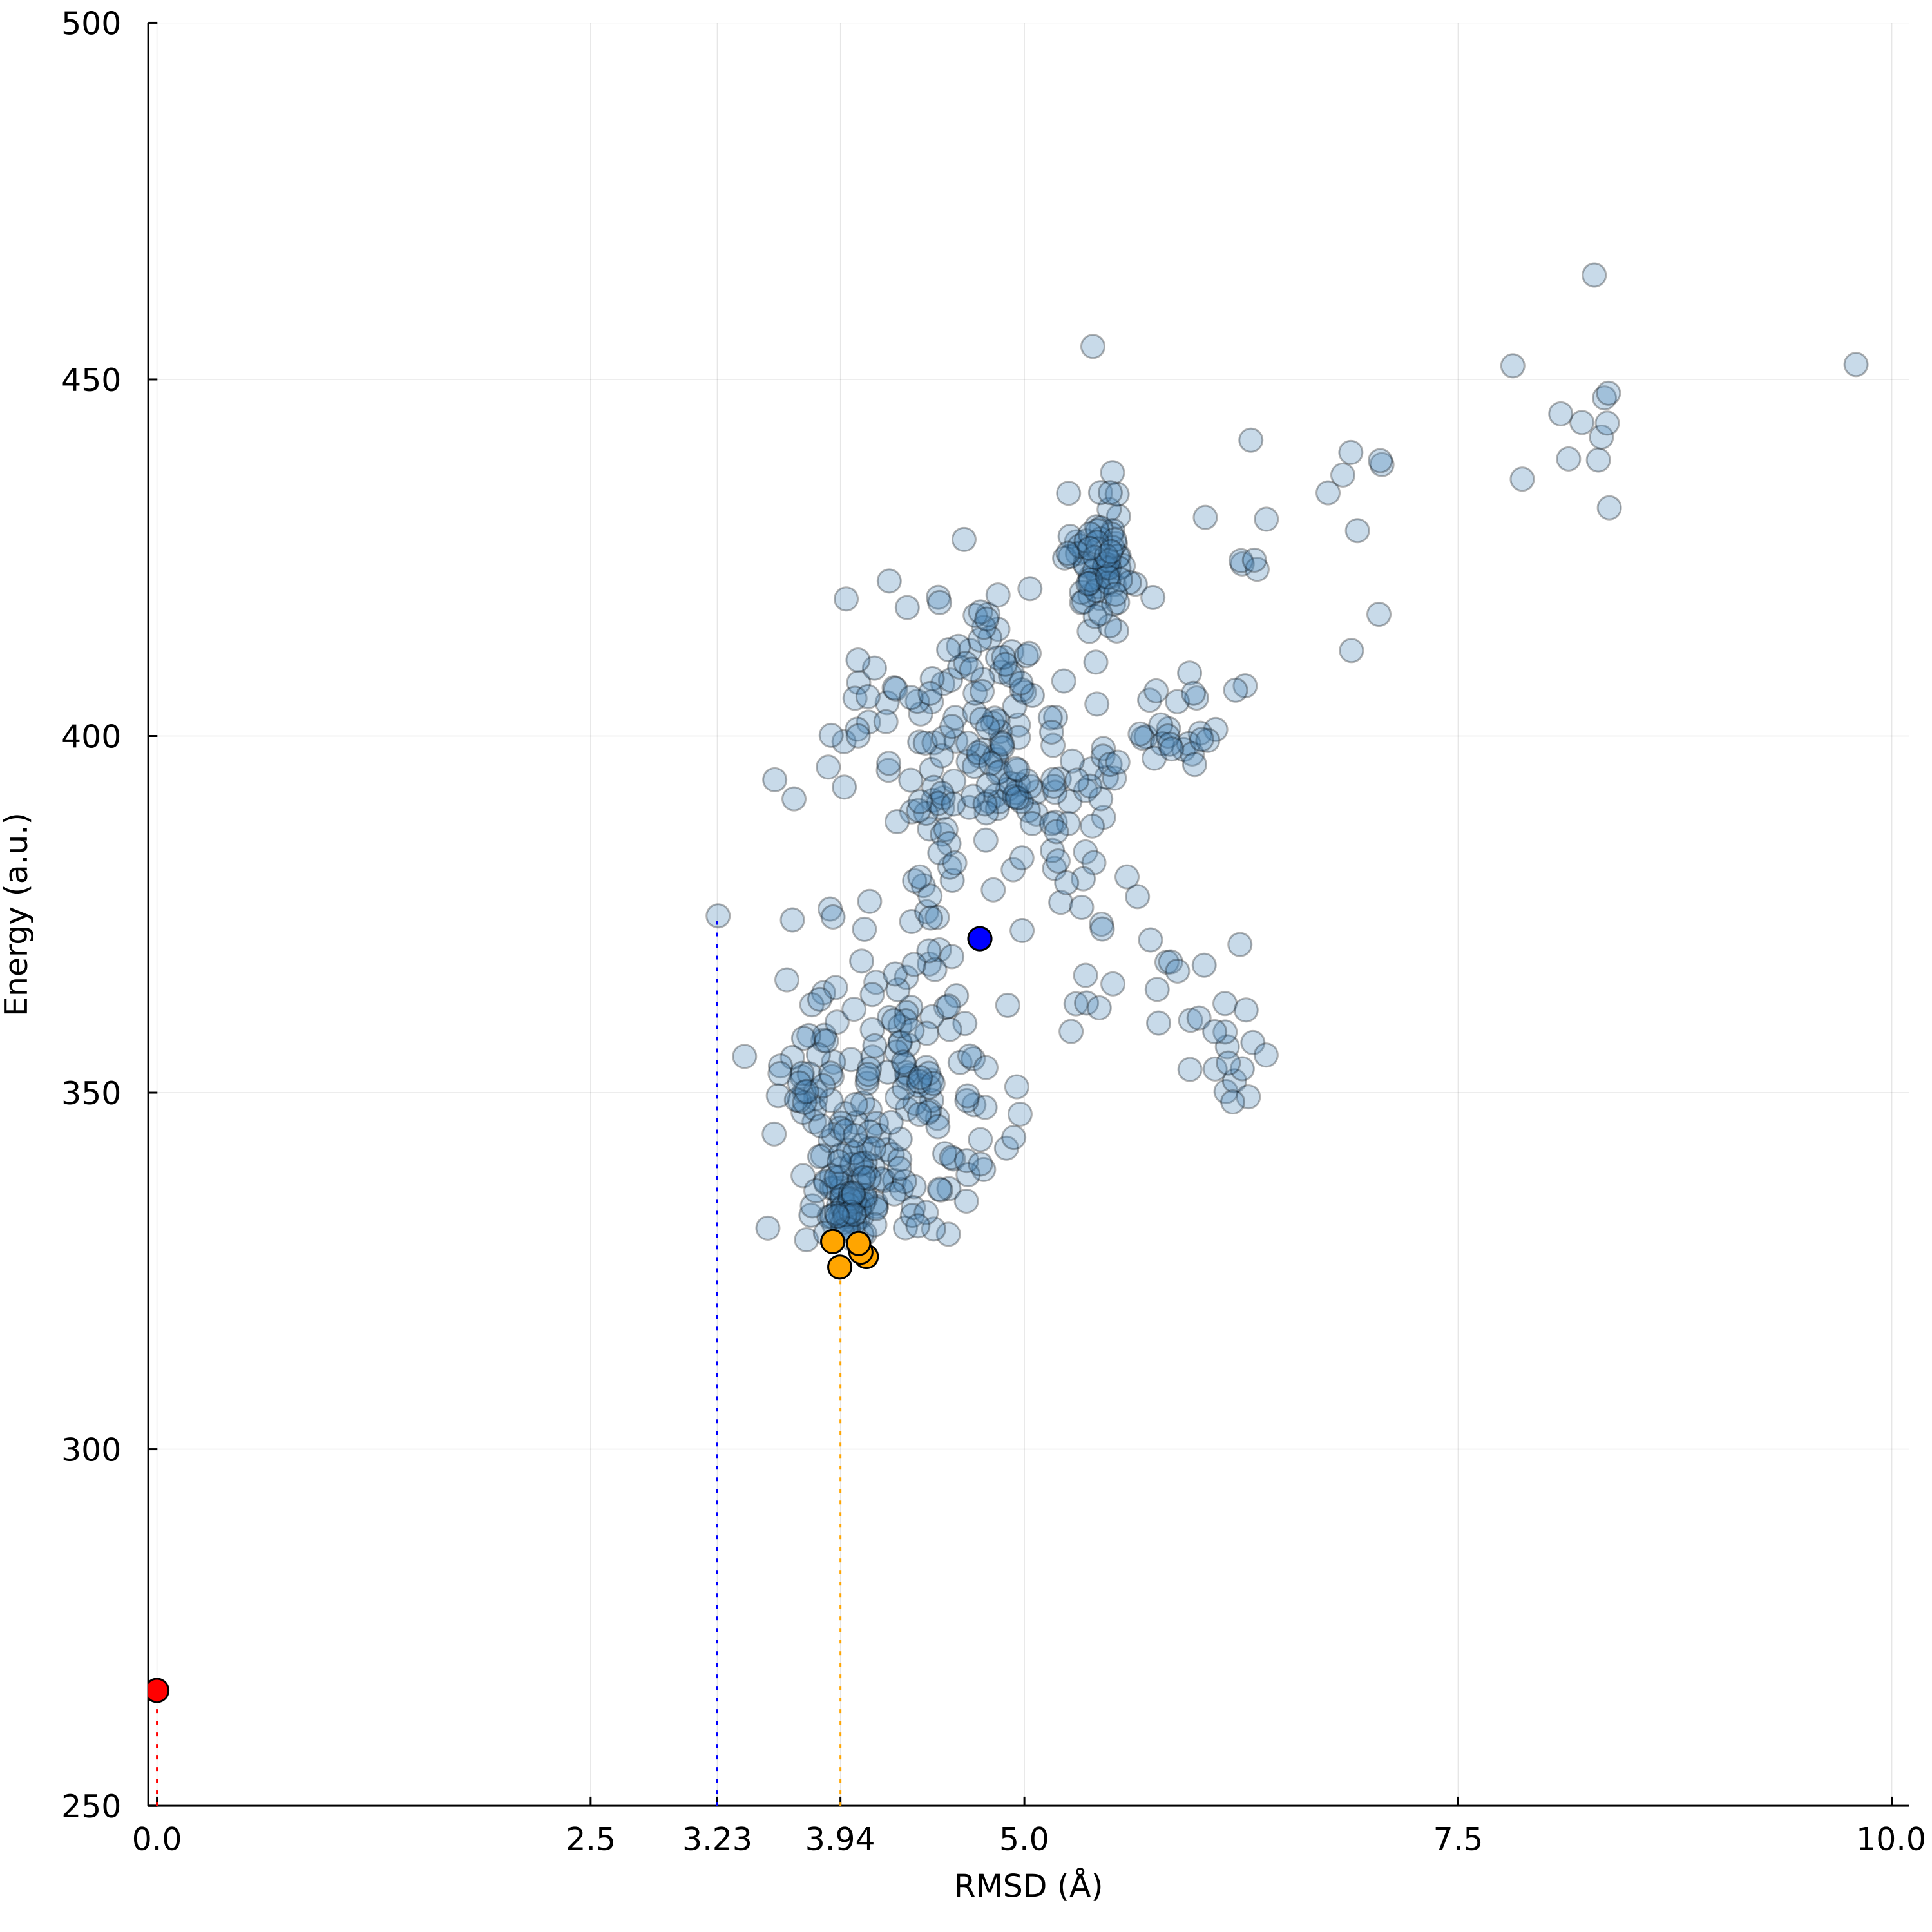

In [20]:
t = [0.0, 2.5, 3.23, 3.94, 5.0, 7.5, 10.0]
p2 = scatter(rmsd[2:end], o_energies[2:end], legend = false, alpha = 0.3, msw = 0.5, color = :steelblue, ylabel = "Energy (a.u.)", xlabel = "RMSD (Å)",
    xlim=(-0.05,10.1), ylim=(250, 500), dpi=300, size=(1000,1000), msize = 7.0, xticks = (t, string.(t)),
    xtickfontsize = 11, ytickfontsize = 11, guidefontsize = 11)
scatter!(o_rmsd_sorted[1:N], o_energies_sorted[1:N], color = :orange, msw = 0.5, msize = 7.0)
scatter!(rmsd[1:1], o_energies[1:1], color = :red, msw = 0.5, msize = 7.0)
scatter!(o_rmsd_sorted[279:279], o_energies_sorted[279:279], color = :blue, msw = 0.5, msize = 7.0)
x = [1, 2]
y = [(300, 500), (300, 400)]
plot!([3.94, 3.94], [0, 325.53834788176016], c = :orange, line = :dot)
plot!([3.23, 3.23], [0, 374.77502738524925], c = :blue, line = :dot)
plot!([0.0, 0.0], [0, 266.177], c = :red, line = :dot)

# savefig("test.png")

Some details on the selected poses:

In [21]:
using Printf

@printf "%23s %d\n" "N :" length(rmsd)

println("\n   Old energy function ----------")
@printf "%23s %.2f Å - Pose #%d\n" "Minimum RMSD ($(argmin(o_rmsd_sorted))) :" minimum(o_rmsd_sorted) o_perm[argmin(o_rmsd_sorted)]
@printf "%23s %.2f Å - Pose #%d\n" "Min. Energy RMSD (1) :" o_rmsd_sorted[1] o_perm[1]
@printf "%23s %.2f Å\n" "Average RMSD     :" (sum(o_rmsd_sorted[1:N]) / N)

                    N : 617

   Old energy function ----------
   Minimum RMSD (289) : 3.23 Å - Pose #245
 Min. Energy RMSD (1) : 3.94 Å - Pose #5
     Average RMSD     : 4.00 Å


3. The next snippet allows users to visualize the Δe constribution of each energy function components (and adjust the α weight on the encopassing energy function for the next run attempt).

In [22]:
ProtoSyn.write(posesenergy_components = collect(keys(poses[1].state.e))
results = Dict{Symbol, Vector{Float64}}()
for energy_component in energy_components
    results[energy_component] = Vector{Float64}()
end

_poses = poses[2 .< rmsd .< 7]
for pose in _poses
    for energy_component in energy_components
        push!(results[energy_component], pose.state.e[energy_component])
    end
end

diff = Dict{String, Float64}()
for (energy_component, values) in results
    diff[String(energy_component)] = maximum(values) - minimum(values)
end

display(diff)
bar(diff, xrotation = 10)[245], "245_candidate.pdb")